In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src import constants as Con

from src.predictive_modeling.answer_correctness.answer_correctness_data import (
    build_trial_level_full_features_for_correctness,
)
from src.predictive_modeling.answer_correctness.answer_correctness_models import (
    MajorityBaselineCorrectness,
    AreaMetricsCorrectnessLogRegModel,
    DerivedFeaturesCorrectnessLogRegModel,
    FullFeaturesCorrectnessLogRegModel,
)
from src.predictive_modeling.answer_correctness.answer_correctness_eval import (
    evaluate_models_on_answer_correctness,
    evaluate_models_on_answer_correctness_leave_one_trial_out,
)
from src.predictive_modeling.answer_correctness.answer_correctness_viz import (
    plot_coef_summary_barh,
    show_correctness_model_results,
    plot_top_abs_coef_feature_frequency_across_participants,
)
from src.predictive_modeling.common.viz_utils import plot_confusion_heatmap

from src.predictive_modeling.answer_correctness.answer_correctness_participant_similarity import (
    build_participant_clustering_inputs,
    build_participant_family_clustering_inputs,
    default_feature_families,
)
from src.predictive_modeling.answer_correctness.answer_correctness_participant_similarity_metrics import (
    compute_distance_matrix,
    evaluate_k_range_silhouette,
    evaluate_k_range_davies_bouldin,
    cophenetic_correlation,
    permutation_silhouette_baseline,
)
from src.predictive_modeling.answer_correctness.answer_correctness_participant_similarity_viz import (
    hierarchical_cluster_participants,
    plot_participant_dendrogram,
    compute_participant_umap,
    plot_participant_umap,
)
from src.predictive_modeling.answer_correctness.answer_correctness_participant_similarity_centroids import (
    compute_cluster_centroids,
    plot_cluster_centroids_barh,
)

C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hunters = pd.read_csv("../data/hunters.csv")
gatherers = pd.read_csv("../data/gatherers.csv")
all_participants = pd.concat([hunters, gatherers], ignore_index=True)

In [3]:
correctness_models = [
    MajorityBaselineCorrectness(),
    AreaMetricsCorrectnessLogRegModel(),
    DerivedFeaturesCorrectnessLogRegModel(),
    FullFeaturesCorrectnessLogRegModel(),
]

pref_specs = [
    (Con.MEAN_DWELL_TIME, "high"),
    (Con.MEAN_FIXATIONS_COUNT, "high"),
    (Con.MEAN_FIRST_FIXATION_DURATION, "high"),
    (Con.SKIP_RATE, "low"),
    (Con.AREA_DWELL_PROPORTION, "high"),
    (Con.MEAN_AVG_FIX_PUPIL_SIZE, "high"),
    (Con.MEAN_MAX_FIX_PUPIL_SIZE, "high"),
    (Con.MEAN_MIN_FIX_PUPIL_SIZE, "low"),
    (Con.FIRST_ENCOUNTER_AVG_PUPIL_SIZE, "high"),
]

In [4]:
def build_trial_df(d: pd.DataFrame, group_cols):
    return build_trial_level_full_features_for_correctness(
        d,
        group_cols=group_cols,
        pref_specs=pref_specs,
    )

MODEL_NAME_FOR_ANALYSIS = "full_features_correctness_log_reg"

In [5]:
results_all_corr_full = evaluate_models_on_answer_correctness(
    df=all_participants,
    models=correctness_models,
    group_cols=(Con.PARTICIPANT_ID, Con.TRIAL_ID),
    split_group_cols=[Con.PARTICIPANT_ID, Con.TRIAL_ID],
    builder_fn=build_trial_df,
)

show_correctness_model_results(results_all_corr_full)

MODEL: majority_baseline
----------------------------------------------------------------------
Number of test trials: 3887
Accuracy: 0.836
Positive (correct) trials: 3249
Negative (incorrect) trials: 638

Precision / Recall / F1 (per class):
         precision  recall    f1  support
class_0      0.000   0.000 0.000      638
class_1      0.836   1.000 0.911     3249

Averages:
  macro   P/R/F1: 0.418 / 0.500 / 0.455
  weighted P/R/F1: 0.699 / 0.836 / 0.761

Confusion Matrix:
        pred_0  pred_1
true_0       0     638
true_1       0    3249

MODEL: area_metrics_correctness_log_reg
----------------------------------------------------------------------
Number of test trials: 3887
Accuracy: 0.769
Positive (correct) trials: 3249
Negative (incorrect) trials: 638

Precision / Recall / F1 (per class):
         precision  recall    f1  support
class_0      0.394   0.759 0.519      638
class_1      0.942   0.771 0.848     3249

Averages:
  macro   P/R/F1: 0.668 / 0.765 / 0.683
  weighted P/R/

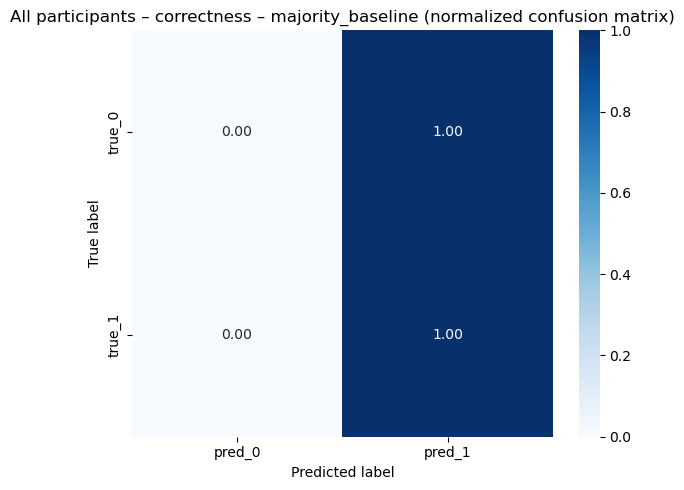

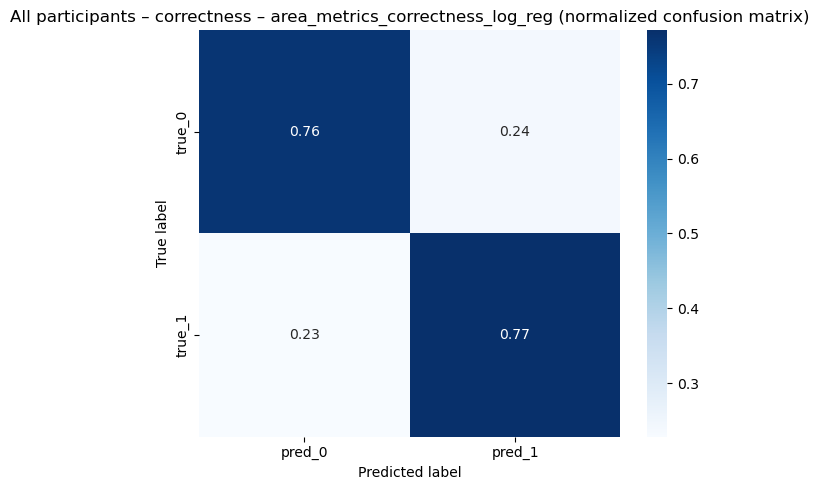

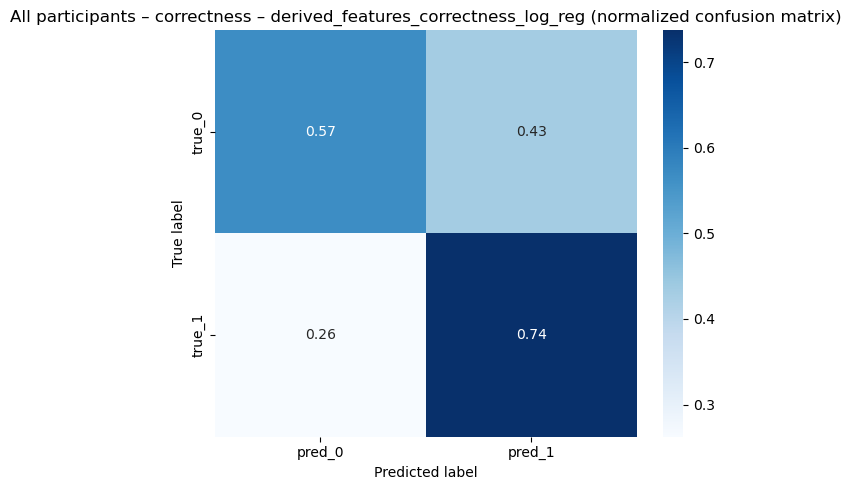

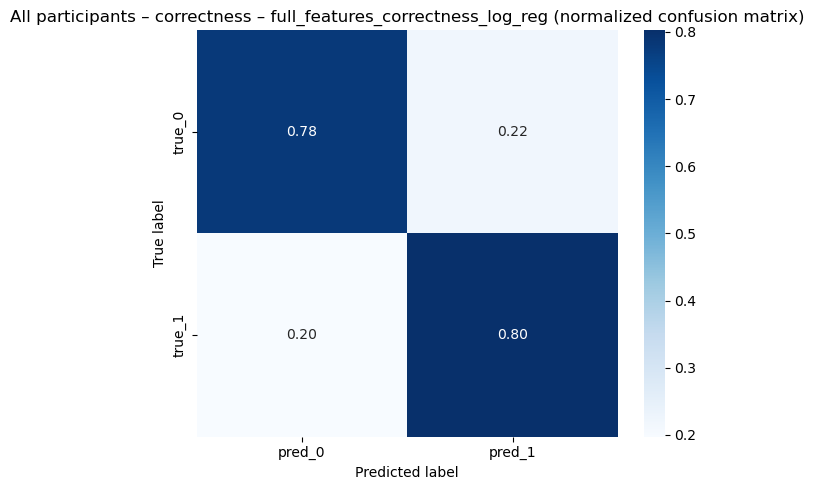

In [6]:
for name, res in results_all_corr_full.items():
    plot_confusion_heatmap(
        y_true=res.y_true,
        y_pred=res.y_pred,
        labels=(0, 1),
        include_minus1=False,
        normalize=True,
        title=f"All participants – correctness – {name} (normalized confusion matrix)",
    )

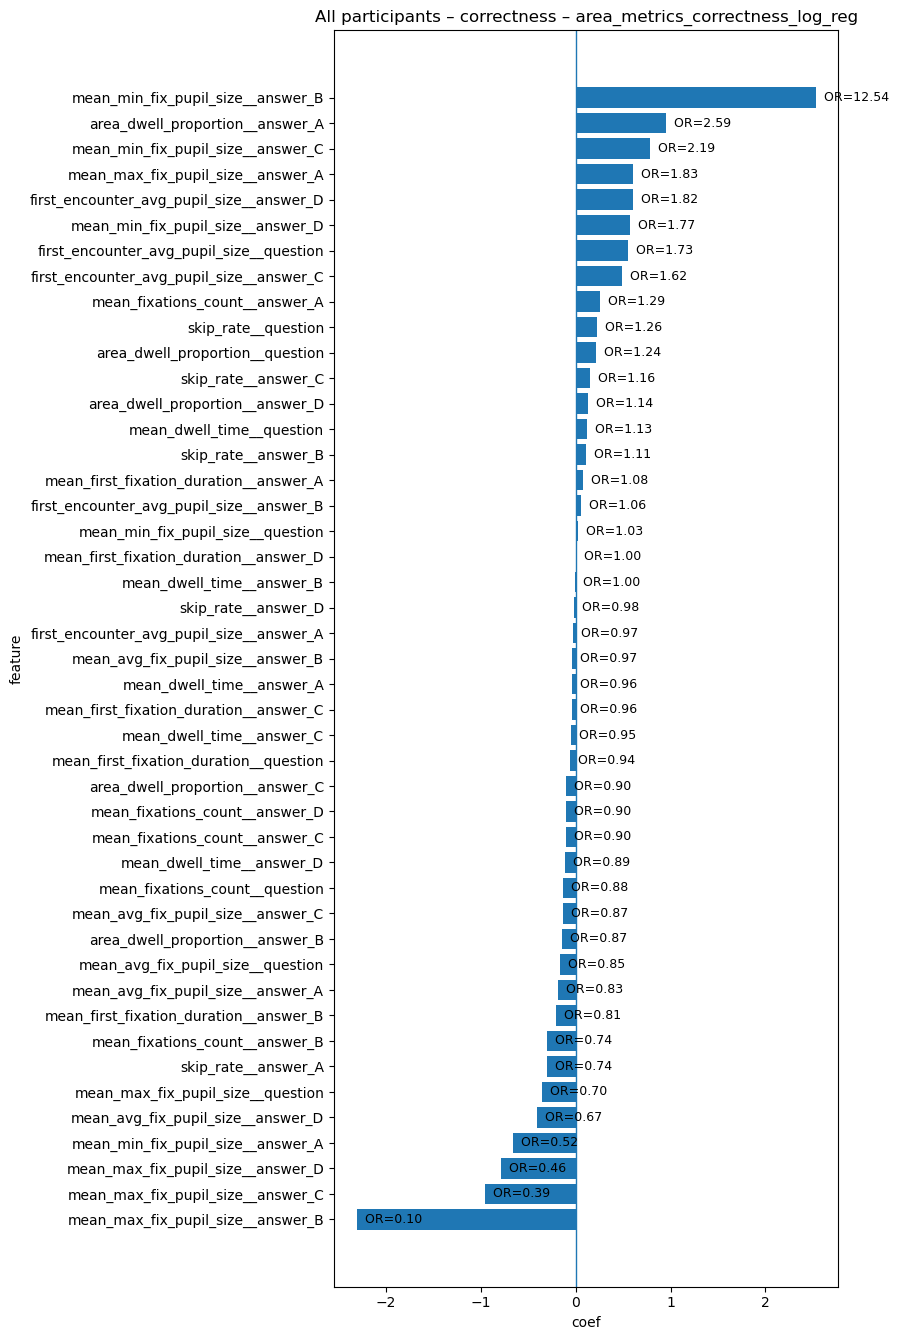

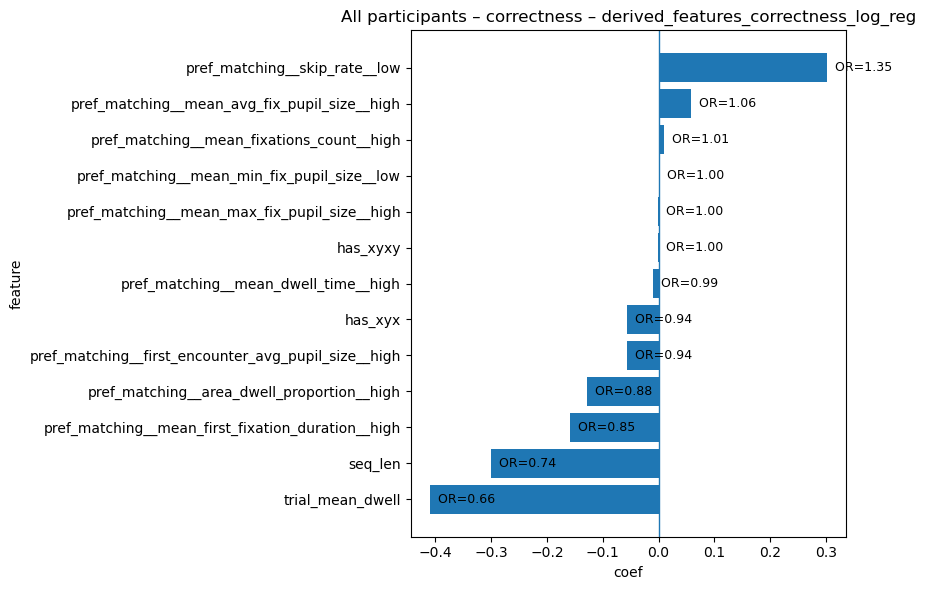

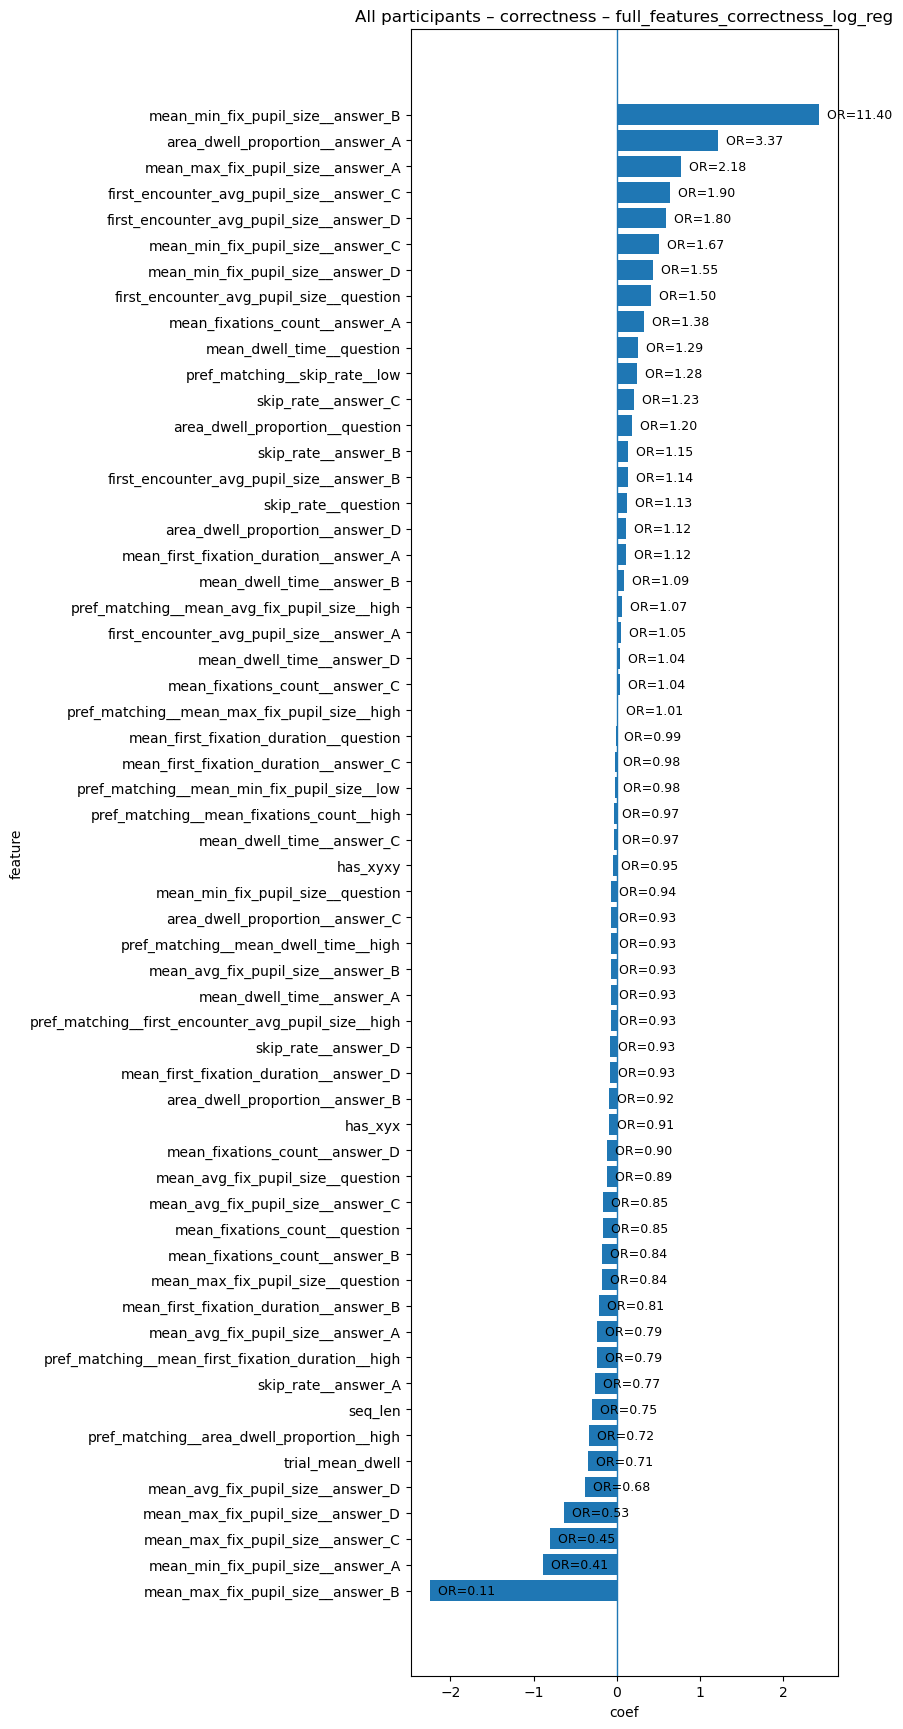

In [7]:
for model_name, res in results_all_corr_full.items():
    if res.coef_summary is None or res.coef_summary.empty:
        continue

    fig, _ = plot_coef_summary_barh(
        coef_summary=res.coef_summary,
        value_col="coef",
        model_name=model_name,
        title=f"All participants – correctness – {model_name}",
        save=True,
    )


In [8]:
results_by_pid = evaluate_models_on_answer_correctness_leave_one_trial_out(
    df=all_participants,
    models=correctness_models,
    group_cols=(Con.PARTICIPANT_ID, Con.TRIAL_ID),
    builder_fn=build_trial_df,
)

In [9]:
# base_out = "../reports/plots/participent_correctness_coeffs"
# for pid, per_model in results_by_pid.items():
#     for model_name, res in per_model.items():
#         if res.coef_summary is None or res.coef_summary.empty:
#             continue
#
#         save_path = os.path.join(base_out, model_name, f"{pid}.png")
#         os.makedirs(os.path.dirname(save_path), exist_ok=True)
#
#         fig, _ = plot_coef_summary_barh(
#             coef_summary=res.coef_summary,
#             value_col="coef",
#             model_name=model_name,
#             title=f"Participant {pid} – correctness – {model_name}",
#             save=True,
#             output_dir=os.path.dirname(save_path),  # uses its built-in filename unless you added save_path support
#         )
#         plt.close(fig)

,feature,count,n_pos,n_neg,n_zero,total_occ,prop,sign_varies,majority_sign,minority_count
11,mean_avg_fix_pupil_size__answer_D,1,1,0,0,1,0.002809,False,1,0
31,mean_min_fix_pupil_size__answer_D,1,1,0,0,1,0.002809,False,1,0
29,mean_max_fix_pupil_size__answer_D,1,0,1,0,1,0.002809,False,-1,0
6,first_encounter_avg_pupil_size__answer_B,2,2,0,0,2,0.005618,False,1,0
28,mean_max_fix_pupil_size__answer_C,2,0,2,0,2,0.005618,False,-1,0
27,mean_max_fix_pupil_size__answer_A,3,2,1,0,3,0.008427,True,1,1
26,mean_fixations_count__question,3,1,2,0,3,0.008427,True,-1,1
8,first_encounter_avg_pupil_size__answer_D,3,3,0,0,3,0.008427,False,1,0
30,mean_min_fix_pupil_size__answer_A,5,2,3,0,5,0.014045,True,-1,2
16,mean_dwell_time__question,5,0,5,0,5,0.014045,False,-1,0


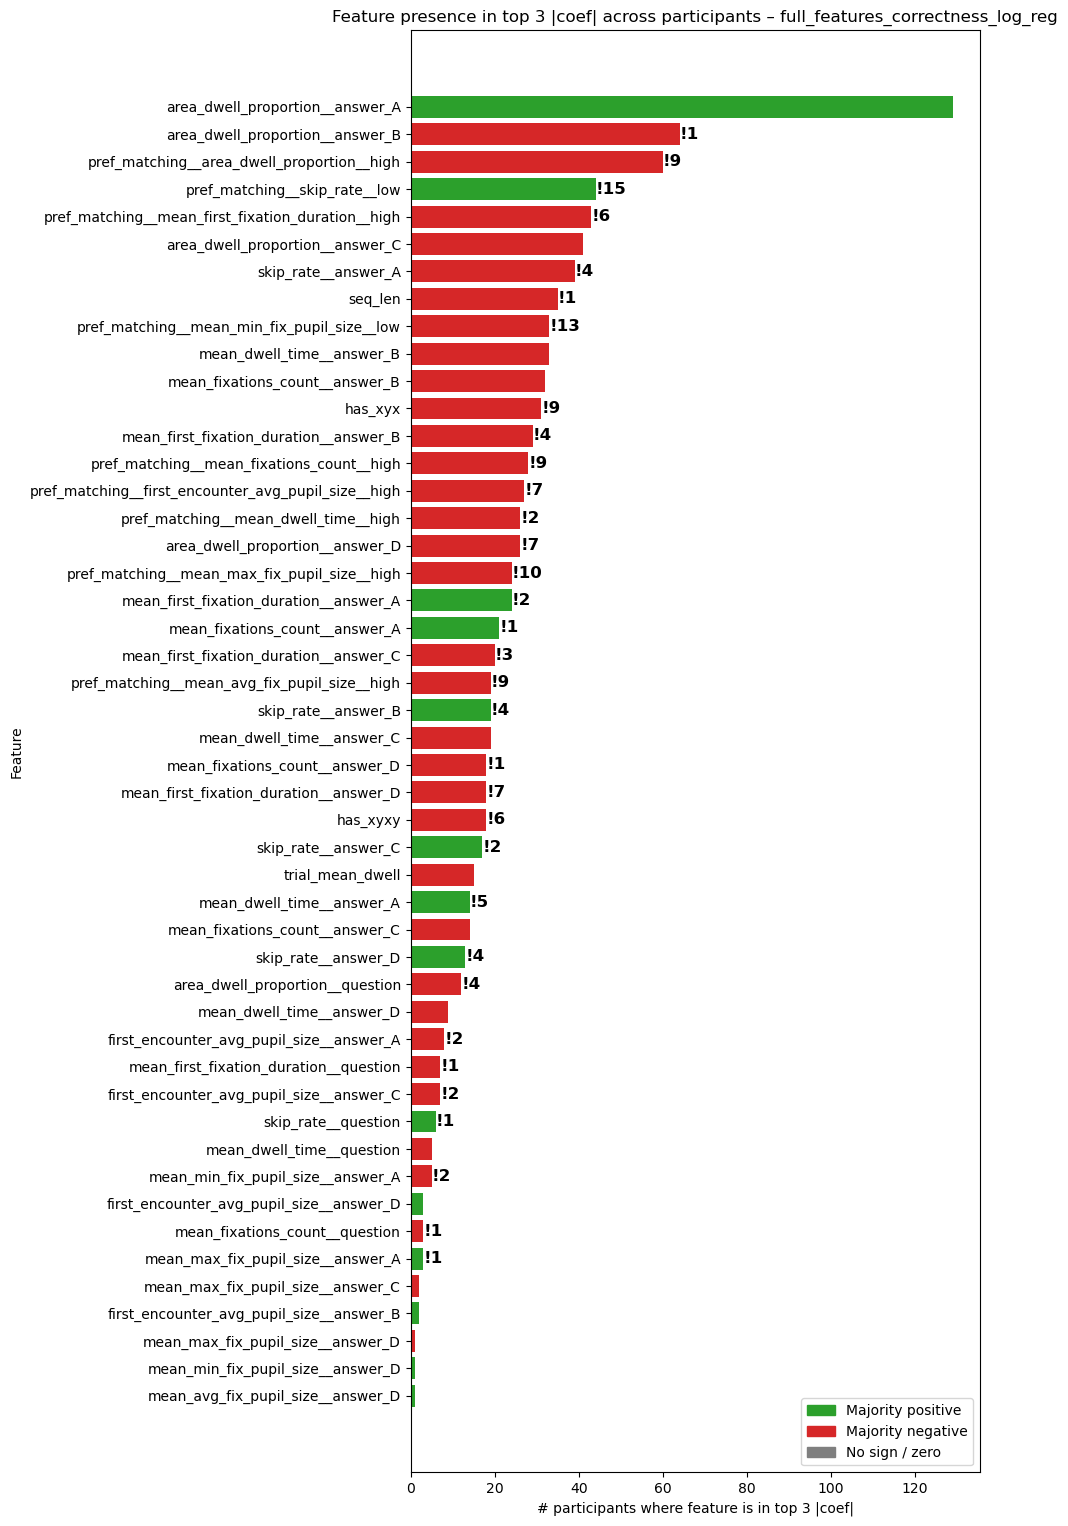

In [10]:
TOP_K_WITHIN_PARTICIPANT = 3
TOP_K_FEATURES_TO_SHOW = 70

fig, summary_df = plot_top_abs_coef_feature_frequency_across_participants(
    results_by_pid=results_by_pid,
    model_name=MODEL_NAME_FOR_ANALYSIS,
    coef_col="coef",
    top_k_within_participant=TOP_K_WITHIN_PARTICIPANT,
    top_k_features=TOP_K_FEATURES_TO_SHOW,
    save_path=f"../reports/plots/participent_correctness_coeffs/"
              f"top{TOP_K_WITHIN_PARTICIPANT}_presence_{MODEL_NAME_FOR_ANALYSIS}.png",
)
summary_df

In [17]:
def run_cluster_goodness_suite(
    X: pd.DataFrame,
    *,
    metric: str = "cosine",
    linkage_method: str = "average",
    k_range: range = range(2, 11),
    k_null: int = 5,
    n_permutations: int = 500,
    random_state: int = 42,
):
    """
    Prints and returns:
      - silhouette across k
      - davies-bouldin across k
      - cophenetic correlation
      - permutation silhouette baseline for k_null
    """
    sil_df = evaluate_k_range_silhouette(
        X, distance_metric=metric, linkage_method=linkage_method, k_range=k_range
    )
    db_df = evaluate_k_range_davies_bouldin(
        X, linkage_method=linkage_method, k_range=k_range, normalize_rows_l2=True
    )
    D = compute_distance_matrix(X, metric=metric)
    coph = cophenetic_correlation(D, linkage_method=linkage_method)
    null_res = permutation_silhouette_baseline(
        X,
        distance_metric=metric,
        linkage_method=linkage_method,
        n_clusters=k_null,
        n_permutations=n_permutations,
        random_state=random_state,
    )

    print(sil_df)
    print(db_df)
    print("cophenetic correlation:", coph)
    print(null_res)

    return sil_df, db_df, coph, null_res

    k  silhouette
0   2    0.059359
1   3    0.047969
2   4    0.042290
3   5    0.035383
4   6    0.036295
5   7    0.030215
6   8    0.034072
7   9    0.033944
8  10    0.026638
    k  davies_bouldin
0   2        5.003732
1   3        4.647770
2   4        4.273854
3   5        4.063634
4   6        3.925324
5   7        3.895465
6   8        3.911735
7   9        3.696342
8  10        3.562373
cophenetic correlation: 0.33723075646581374
{'real_silhouette': 0.03538288366760821, 'null_mean': 0.013745823215266038, 'null_std': 0.002094752706308758, 'z_score': 10.329171738113967}


C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


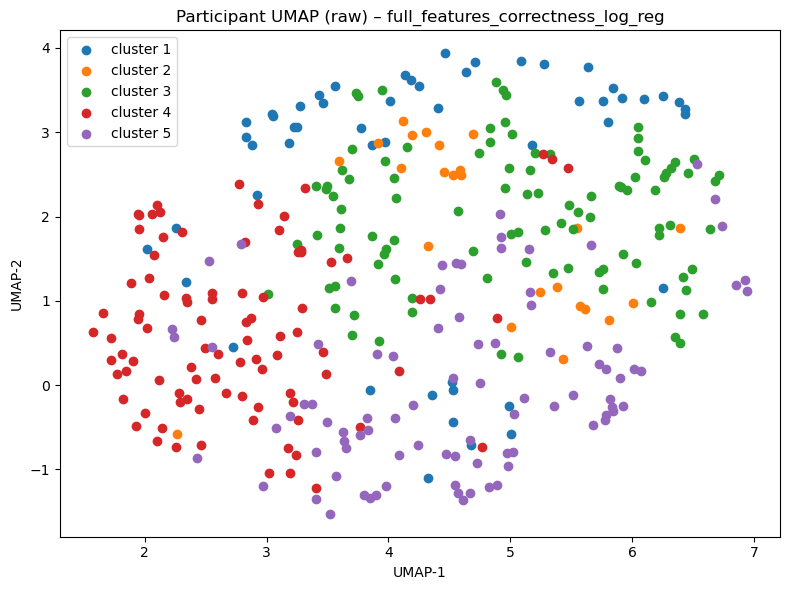

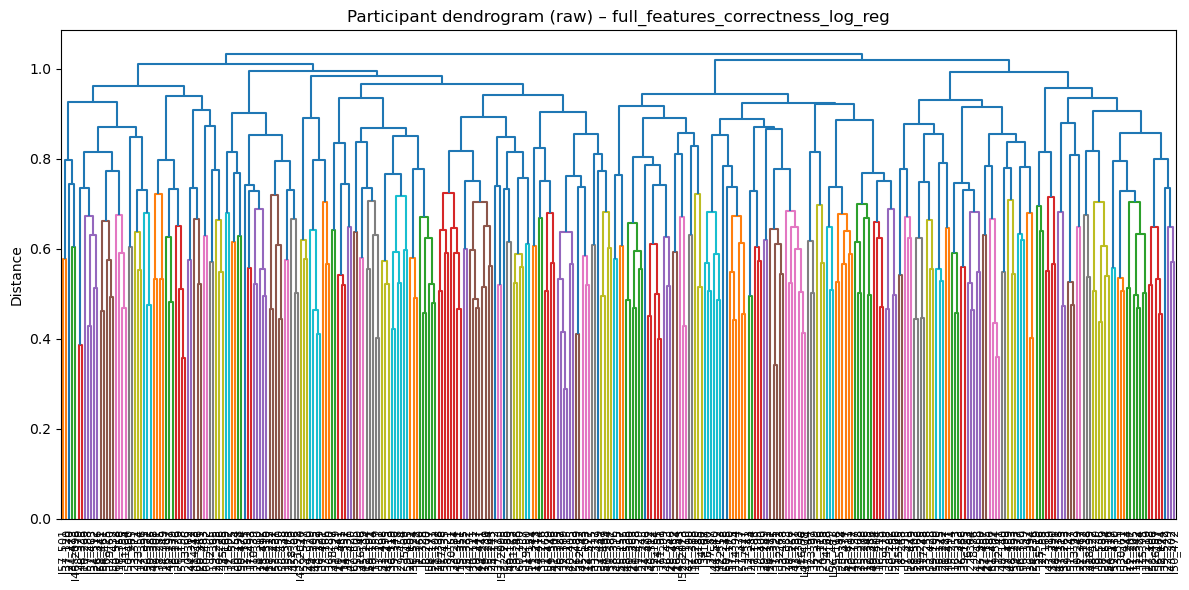

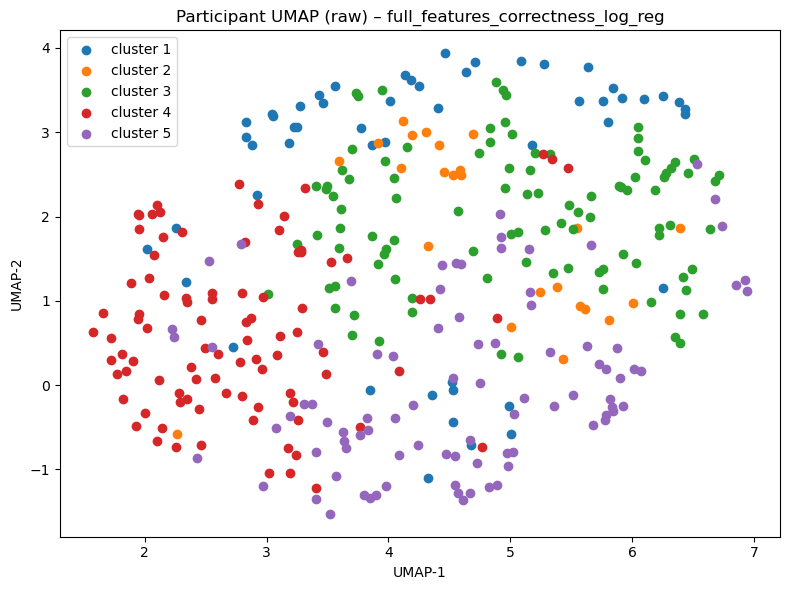

In [13]:
#  Participant similarity (raw coefficient vectors)
model_name = MODEL_NAME_FOR_ANALYSIS

inputs_raw = build_participant_clustering_inputs(
    results_by_pid=results_by_pid,
    model_name=model_name,
    coef_col="coef",
    zscore=True,
)

# --- goodness checks
run_cluster_goodness_suite(inputs_raw.coef_matrix_z, k_null=5)

# --- clustering + plots
D_raw = compute_distance_matrix(inputs_raw.coef_matrix_z, metric="cosine")
clust_raw = hierarchical_cluster_participants(
    D_raw, linkage_method="average", cut_mode="n_clusters", n_clusters=5
)

out_dir_raw = f"../reports/plots/participant_similarity/correctness/{model_name}/raw"
plot_participant_dendrogram(
    clust_raw,
    title=f"Participant dendrogram (raw) – {model_name}",
    save_path=os.path.join(out_dir_raw, "dendrogram.png"),
)

umap_xy_raw = compute_participant_umap(inputs_raw.coef_matrix_z, metric="cosine")
plot_participant_umap(
    umap_xy_raw,
    labels=clust_raw.labels,
    title=f"Participant UMAP (raw) – {model_name}",
    save_path=os.path.join(out_dir_raw, "umap.png"),
)

    k  silhouette
0   2    0.230830
1   3    0.230611
2   4    0.215647
3   5    0.202099
4   6    0.208489
5   7    0.213134
6   8    0.187577
7   9    0.194213
8  10    0.187805
    k  davies_bouldin
0   2        2.478961
1   3        2.052021
2   4        1.977652
3   5        1.832673
4   6        1.679515
5   7        1.640339
6   8        1.683781
7   9        1.634945
8  10        1.544106
cophenetic correlation: 0.5105880817990739
{'real_silhouette': 0.20209928379795794, 'null_mean': 0.1587277798225661, 'null_std': 0.016527037251878363, 'z_score': 2.624275804210612}


C:\Users\deeth\miniconda3\envs\QA_eyetracking_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


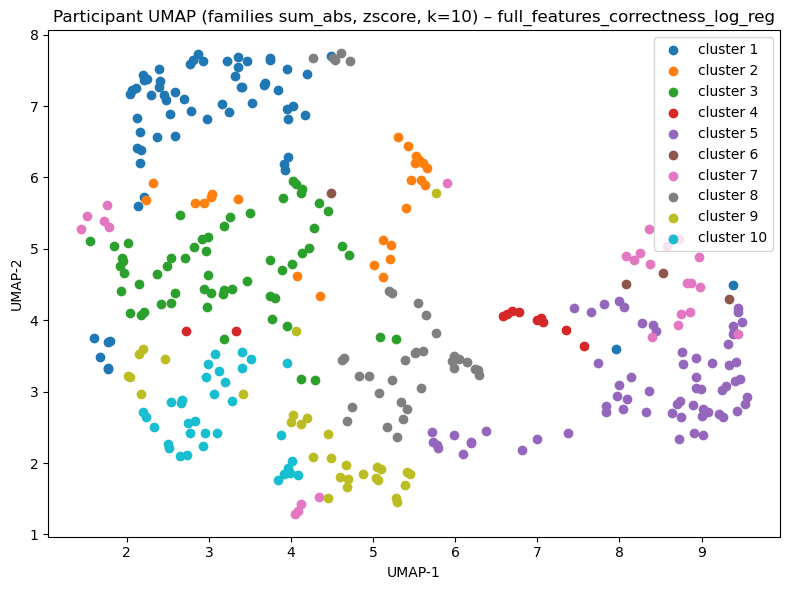

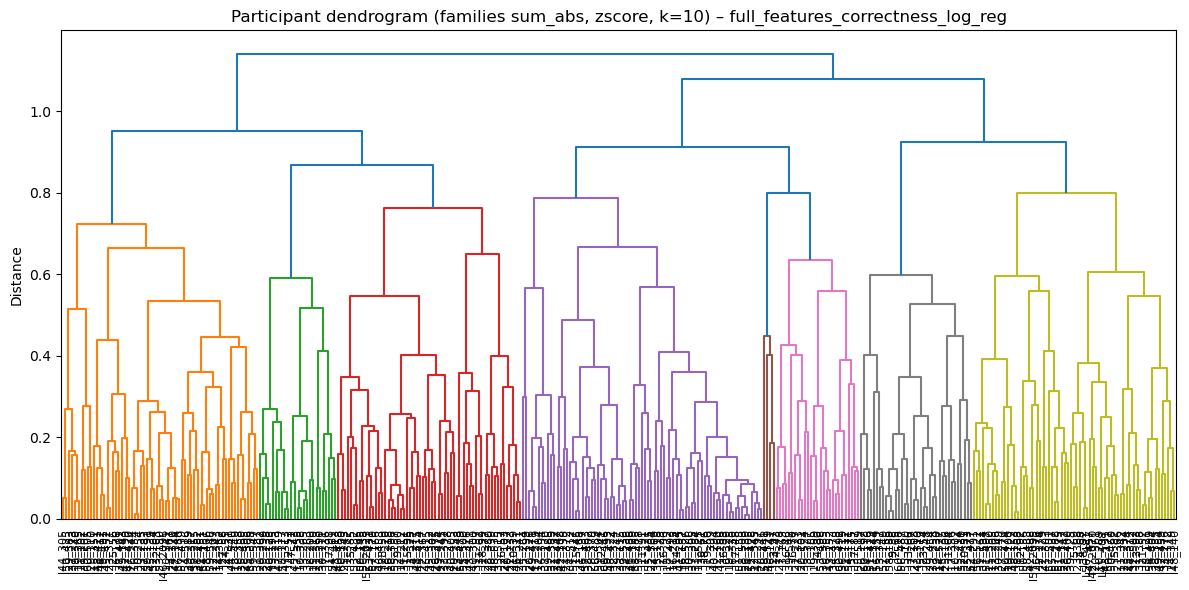

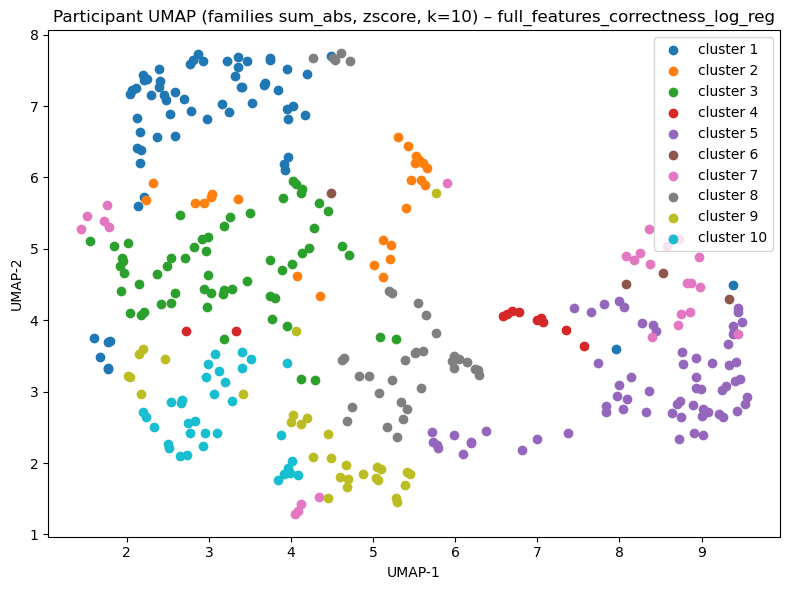

In [23]:
# Participant similarity (family-aggregated coefficient vectors)
fam_agg = "sum_abs"
zscore_flag = True
n_clusters = 10

z_tag = "zscore" if zscore_flag else "noz"
k_tag = f"k{n_clusters}"

fam_inputs = build_participant_family_clustering_inputs(
    results_by_pid=results_by_pid,
    model_name=model_name,
    coef_col="coef",
    families=default_feature_families(),
    family_agg=fam_agg,
    zscore=zscore_flag,
)

# --- goodness checks
run_cluster_goodness_suite(fam_inputs.coef_matrix_z, k_null=5)

# --- clustering + plots
D_fam = compute_distance_matrix(fam_inputs.coef_matrix_z, metric="cosine")

clust_fam = hierarchical_cluster_participants(
    D_fam,
    linkage_method="average",
    cut_mode="n_clusters",
    n_clusters=n_clusters,
)

out_dir_fam = (
    f"../reports/plots/participant_similarity/"
    f"correctness/{model_name}/"
    f"families_{fam_agg}_{z_tag}_{k_tag}"
)

os.makedirs(out_dir_fam, exist_ok=True)
plot_participant_dendrogram(
    clust_fam,
    title=(
        f"Participant dendrogram "
        f"(families {fam_agg}, {z_tag}, k={n_clusters}) – {model_name}"
    ),
    save_path=os.path.join(out_dir_fam, "dendrogram.png"),
)

umap_xy_fam = compute_participant_umap(
    fam_inputs.coef_matrix_z,
    metric="cosine",
)

plot_participant_umap(
    umap_xy_fam,
    labels=clust_fam.labels,
    title=(
        f"Participant UMAP "
        f"(families {fam_agg}, {z_tag}, k={n_clusters}) – {model_name}"
    ),
    save_path=os.path.join(out_dir_fam, "umap.png"),
)

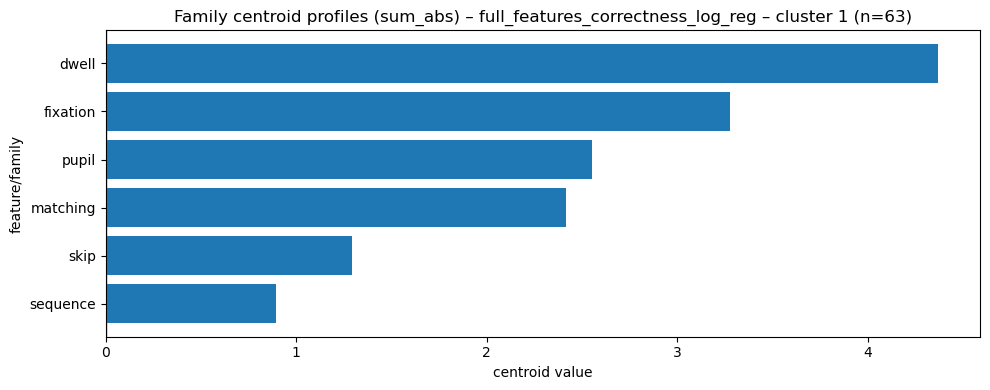

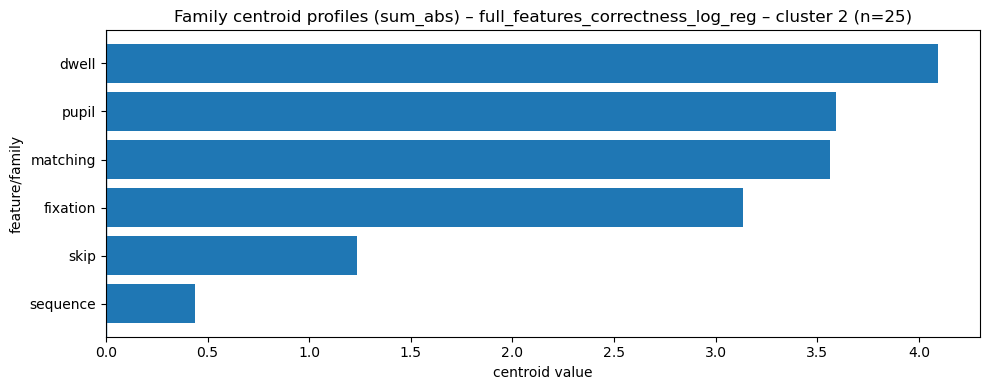

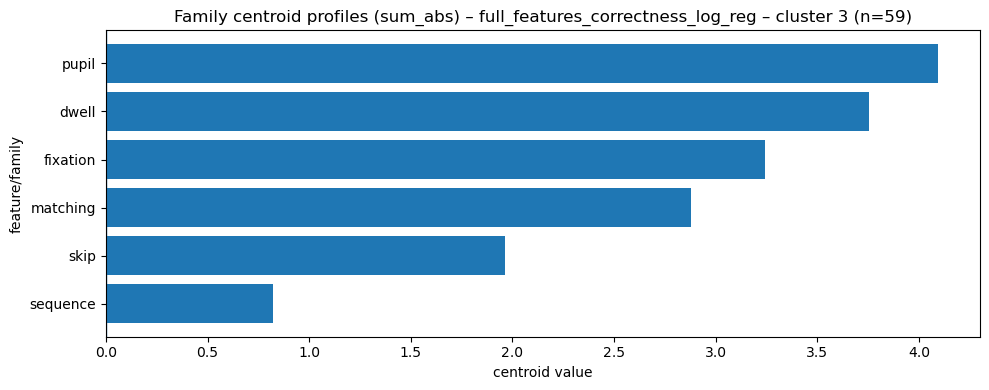

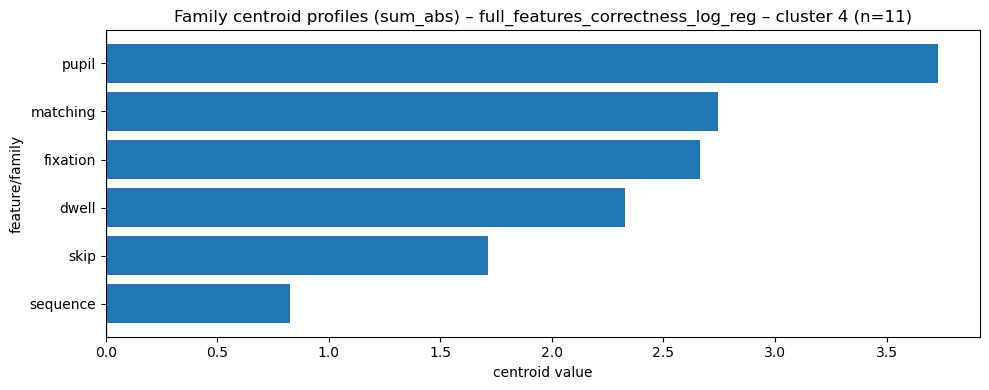

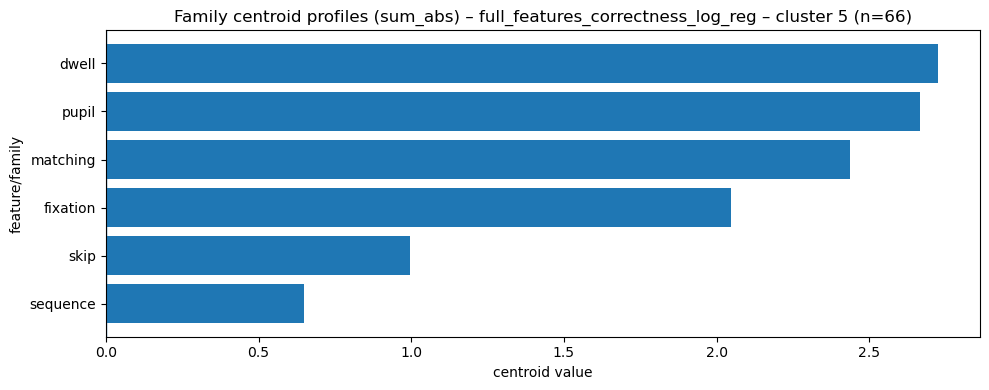

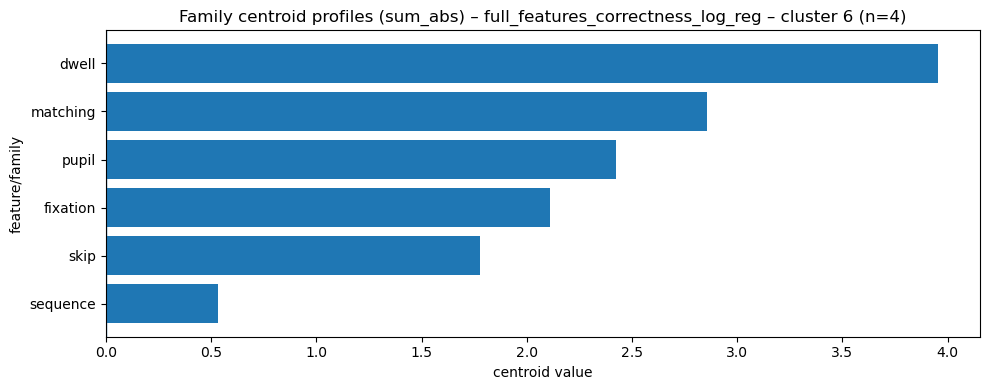

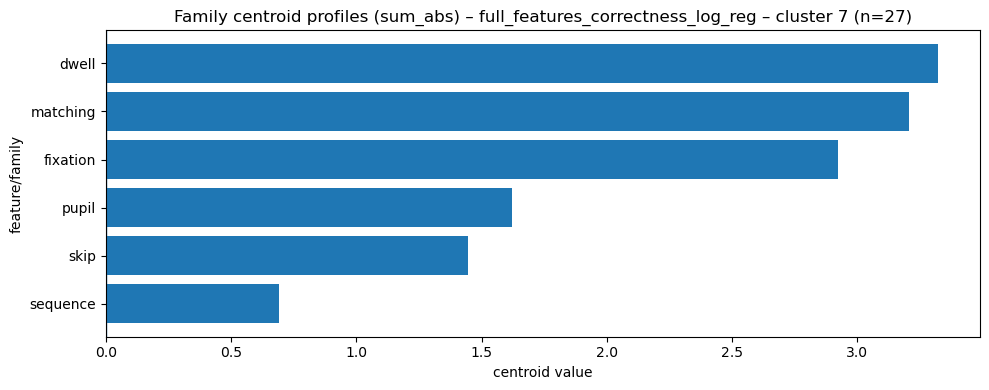

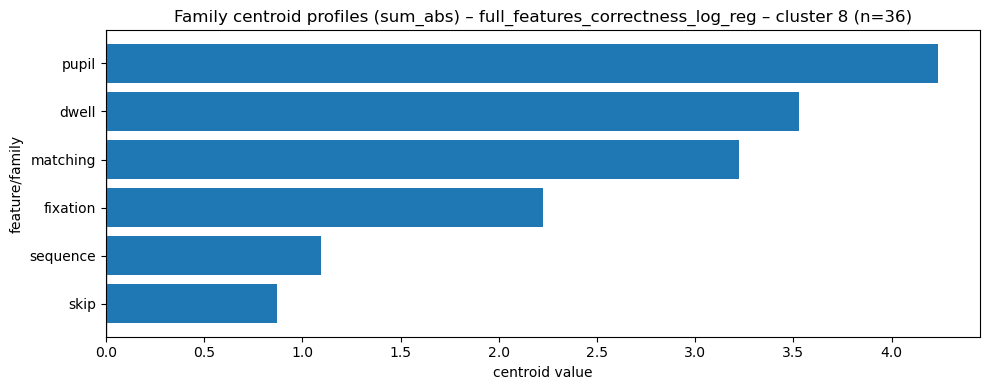

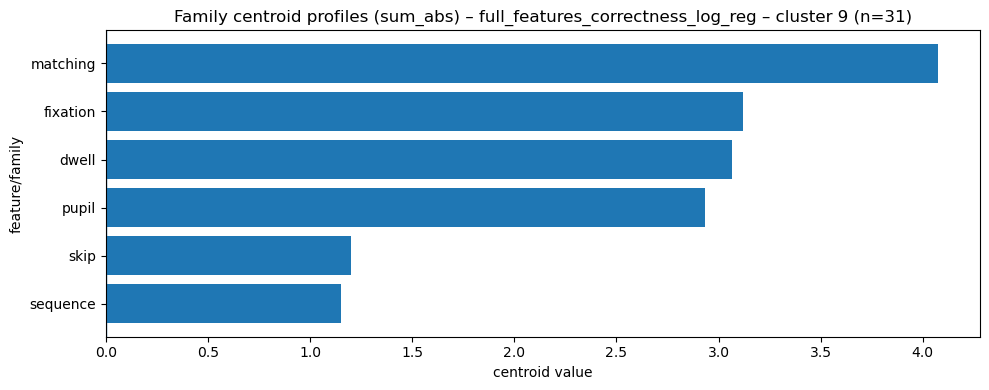

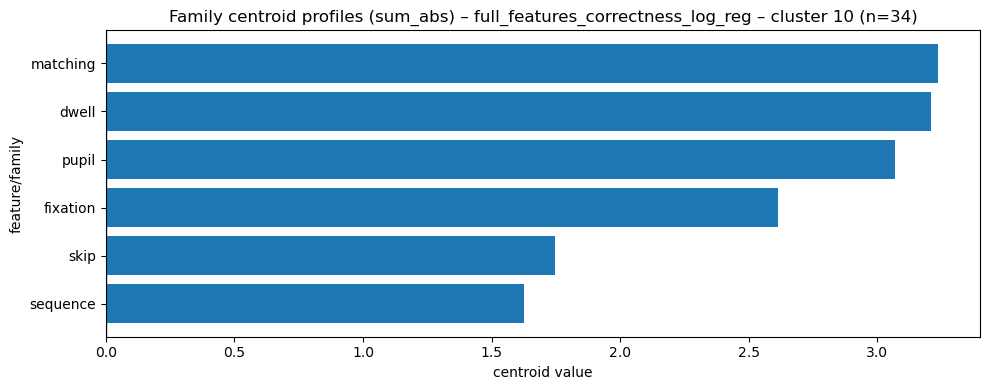

In [24]:
X_fam = fam_inputs.coef_matrix

cent_res = compute_cluster_centroids(
    X=X_fam,
    labels=clust_fam.labels,
    agg="mean",
    top_k=10,
)

# # Save centroid tables for inspection
# cent_res.centroids.to_csv(os.path.join(out_dir_fam, "cluster_centroids.csv"))
# cent_res.counts.to_csv(os.path.join(out_dir_fam, "cluster_sizes.csv"))
# cent_res.top_features.to_csv(os.path.join(out_dir_fam, "cluster_top_features.csv"), index=False)

# Plot one centroid bar chart per cluster
plot_cluster_centroids_barh(
    centroids=cent_res.centroids,
    counts=cent_res.counts,
    top_k=12,
    title=f"Family centroid profiles ({fam_agg}) – {MODEL_NAME_FOR_ANALYSIS}",
    save_path=os.path.join(out_dir_fam, "centroid_cluster{cluster}.png"),
)

In [25]:
from src.predictive_modeling.answer_correctness.answer_correctness_participant_clustering import (
    run_clustering_robustness_grid,
    cluster_kmedoids_pam,
)

X = fam_inputs.coef_matrix_z

robust_df = run_clustering_robustness_grid(
    X,
    n_clusters=5,
    base=("hier", "average"),
    metrics=("cosine", "euclidean"),
    linkages=("average", "complete", "single"),
    kmedoids_metrics=("cosine",),
    random_state=42,
)
robust_df.sort_values(["algo", "metric", "linkage"])


,algo,metric,linkage,n_clusters,base,ari,nmi,medoids,inertia
0,hierarchical,cosine,average,5,hier_average_cosine,1.000000,1.000000,NaN,NaN
1,hierarchical,cosine,complete,5,hier_average_cosine,0.317608,0.427071,NaN,NaN
2,hierarchical,cosine,single,5,hier_average_cosine,-0.002903,0.018306,NaN,NaN
3,hierarchical,euclidean,average,5,hier_average_cosine,0.002972,0.041978,NaN,NaN
4,hierarchical,euclidean,complete,5,hier_average_cosine,0.160069,0.241541,NaN,NaN
5,hierarchical,euclidean,single,5,hier_average_cosine,-0.000221,0.020896,NaN,NaN
6,kmedoids_pam,cosine,,5,hier_average_cosine,0.355945,0.398520,"l54_151,l13_206,l38_396,l29_248,l19_225",131.367475


In [27]:
km = cluster_kmedoids_pam(
    fam_inputs.coef_matrix_z,
    metric="cosine",
    n_clusters=5,
    random_state=42,
)

print("Medoid participant IDs:", km.medoid_ids)
print("Inertia:", km.inertia)
km.labels.value_counts().sort_index()

Medoid participant IDs: ['l54_151', 'l13_206', 'l38_396', 'l29_248', 'l19_225']
Inertia: 131.36747529615423


kmedoids_k5
1    79
2    55
3    89
4    55
5    78
Name: count, dtype: int64